## Part 3. Climate Analysis and Exploration

* Using Python and SQLAlchemy for climate analysis and data exploration on newly created weather station tables. 

* All of the following analysis will be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.


In [1]:
# Importing dependencies
import pandas as pd
import datetime as dt
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Importing Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# Create Database Connection
engine = create_engine("sqlite:///./Resources/hawaii.sqlite", echo=False)

In [4]:
# Inspecting tables in the sqlite database
inspector = inspect(engine)
inspector.get_table_names()

['measures', 'stations']

### Precipitation Analysis

* Designing a query to retrieve the last 12 months of precipitation data.

* Selecting only the `date` and `prcp` values.

* Loading the query results into a Pandas DataFrame and set the index to the date column.

* Ploting the results using the DataFrame `plot` method.

* Using Pandas to print the summary statistics for the precipitation data.

In [5]:
# Getting a list of column names and types
columns = inspector.get_columns('measures')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs INTEGER


In [6]:
# Displaying all data from table "measures"
engine.execute('SELECT * FROM measures LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [7]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measures
Station = Base.classes.stations

In [8]:
session = Session(engine)

In [9]:
# Retrieving a total amount of dates
session.query(func.count(Measurement.date)).all()

[(18103)]

In [10]:
# Retrieving latest date available
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [11]:
# Retrieving the last 12 months of data, last date - 365
year_to_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_to_date)

2016-08-23


In [12]:
# Retrieving the last 12 months of precipitation data.
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_to_date).statement

prcp_year_df = pd.read_sql_query(prcp_query, session.bind)
prcp_year_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [13]:
# Retrieving statistical information
prcp_year_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Converting column to date format
prcp_year_df['date'] = pd.to_datetime(prcp_year_df['date'])

In [15]:
prcp_year_df.dtypes

date    datetime64[ns]
prcp           float64
dtype: object

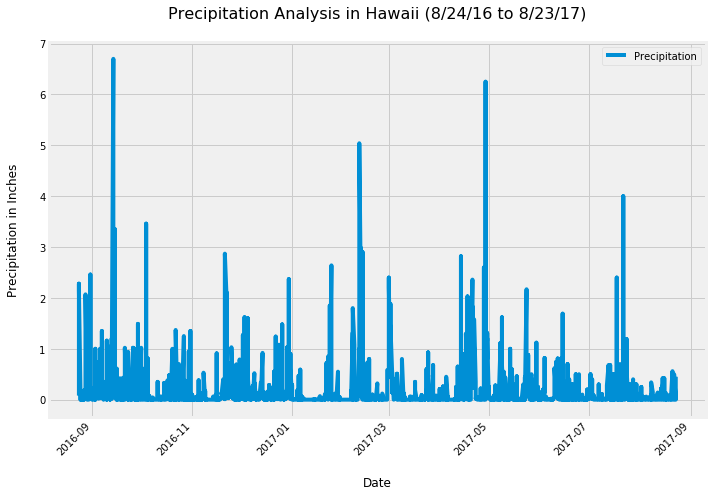

In [16]:
# Plotting a line chart for precipitation data
df1 = pd.DataFrame(prcp_year_df, columns=['date', 'prcp'])
df1.set_index('date', inplace=True)
df1.plot.line(figsize=(10, 7))
plt.xlabel("\nDate")
plt.ylabel("Precipitation in Inches\n")
plt.title("Precipitation Analysis in Hawaii (8/24/16 to 8/23/17)\n", fontsize=16)
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Stations Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

    + List the stations and observation counts in descending order
    + Which station has the highest number of observations?



* Design a query to retrieve the last 12 months of temperature observation data (tobs). 
    - Filter by the station with the highest number of observations.
    - Plot the results as a histogram with bins=12.
        

In [17]:
# Get a list of column names and types
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
engine.execute('SELECT * FROM stations LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [19]:
total_stations = session.query('count(station) FROM stations').all()
print(f"Total weather stations: {total_stations[0][0]}")

Total weather stations: 9


In [20]:
stations_activity = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
filter(Measurement.station == Station.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

In [21]:
print(':::: Weather stations activity ::::')
print()
print('Total count of observations by all stations in descending order:')
print()
for station, name, count, in stations_activity:
    print(f'Station {station}, {name}, had {count} weather observations.')
print()
print(f'MOST ACTIVE STATION: Station {stations_activity[0][0]}, {stations_activity[0][1]}, had the highest activity - {stations_activity[0][2]} weather observations.')

:::: Weather stations activity ::::

Total count of observations by all stations in descending order:

Station USC00519281, WAIHEE 837.5, HI US, had 2772 weather observations.
Station USC00513117, KANEOHE 838.1, HI US, had 2696 weather observations.
Station USC00519397, WAIKIKI 717.2, HI US, had 2685 weather observations.
Station USC00519523, WAIMANALO EXPERIMENTAL FARM, HI US, had 2572 weather observations.
Station USC00516128, MANOA LYON ARBO 785.2, HI US, had 2484 weather observations.
Station USC00514830, KUALOA RANCH HEADQUARTERS 886.9, HI US, had 1937 weather observations.
Station USC00511918, HONOLULU OBSERVATORY 702.2, HI US, had 1932 weather observations.
Station USC00517948, PEARL CITY, HI US, had 683 weather observations.
Station USC00518838, UPPER WAHIAWA 874.3, HI US, had 342 weather observations.

MOST ACTIVE STATION: Station USC00519281, WAIHEE 837.5, HI US, had the highest activity - 2772 weather observations.


In [22]:
# Creating a variable for the most active weather station
max_activity_station = stations_activity[0][0]
max_activity_station

'USC00519281'

In [23]:
# Retrieve the last 12 months of precipitation data collected by the most active station.
max_prcp_query = session.query(Measurement.station, Station. name, Measurement.tobs).\
filter(Measurement.station == max_activity_station, Measurement.date > year_to_date).statement

max_prcp_df = pd.read_sql_query(max_prcp_query, session.bind)
max_prcp_df.set_index('station').head()

,name,tobs
station,,
USC00519281,"WAIKIKI 717.2, HI US",77
USC00519281,"WAIKIKI 717.2, HI US",80
USC00519281,"WAIKIKI 717.2, HI US",80
USC00519281,"WAIKIKI 717.2, HI US",75
USC00519281,"WAIKIKI 717.2, HI US",73


In [24]:
# Printing the most active station
max_prcp_df['station'][0], max_prcp_df['name'][0]

('USC00519281', 'WAIKIKI 717.2, HI US')

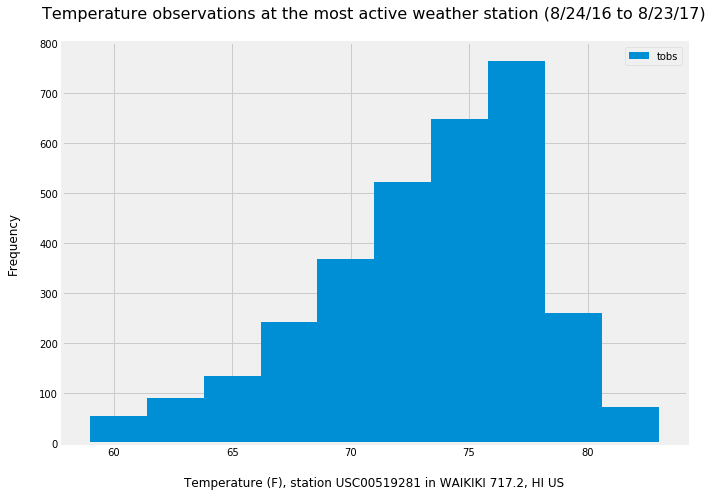

In [25]:
# Plotting a histogram for temprerature observation at the most active station
df1 = pd.DataFrame(max_prcp_df, columns=['tobs'])
df1.plot.hist(figsize=(10, 7))
plt.xlabel('\nTemperature (F), station ' + max_prcp_df['station'][0] + ' in ' +  max_prcp_df['name'][0] )
plt.ylabel("Frequency\n")
plt.title('Temperature observations at the most active weather station (8/24/16 to 8/23/17)\n', fontsize=16)
plt.legend(["tobs"])
plt.figsize = (10,7)
plt.tight_layout()
plt.show()

### Temperature Analysis

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [26]:
# Creating a function that takes in dates and displays a graph with T
import numpy as np
def calc_temp(start, end):
    query = session.query(Measurement.tobs).\
    filter(Measurement.date >= start, Measurement.date <= end).all()
    temperature = [temp[0] for temp in query]
    avg_temp = np.mean(temperature)
    max_temp = max(temperature)
    min_temp = min(temperature)
    
    plt.figure(figsize=(3,5))
    plt.bar(1, avg_temp, yerr=(max_temp - min_temp), tick_label='', color='coral')
    plt.ylabel("Temperature\n")
    plt.title('Average Temperature (' + start + ' to ' + end + ')\n', fontsize = 16)
    plt.show()

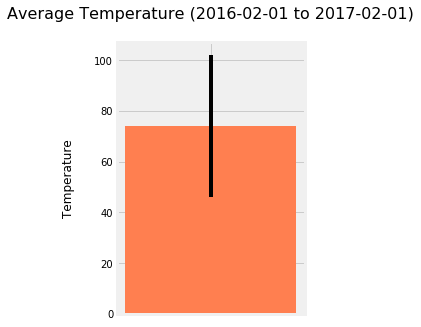

In [27]:
calc_temp(start='2016-02-01', end='2017-02-01')